### Task 1. Form the following block and calculate its hash.

In [1]:
{
    'index': 4,
    'timestamp': 0,
    'previous_hash':'0009e52e043a9f83524d01485dda65fe16b6d0dd4239c1c938834be249a432e3',
    'nonce': 0,
    'author': 'Satoshi',
    'transactions': [
        {
            'sender_address': 'Alice',
            'recipient_address': 'Bob',
            'value': 10,
            'data': 'Hello Bob!',
        },
        {
            'sender_address': 'Bob',
            'recipient_address': 'Alice',
            'value': 5,
            'data': 'Hello Alice!',
        }
    ]
}
pass

#### Solution

In [2]:
from pprint import pprint
from blockchain.block import Block
from blockchain.transaction import Transaction

transactions = [
    Transaction('Alice', 'Bob', 10, 'Hello Bob!'),
    Transaction('Bob', 'Alice', 5, 'Hello Alice!'),
]

b = Block(
    index=4, transactions=transactions, author='Satoshi', timestamp=0, nonce=0,
    previous_hash='0009e52e043a9f83524d01485dda65fe16b6d0dd4239c1c938834be249a432e3'
)
pprint(b.compute_hash())

'e02f8bf9303b7b42b77e313887564761dd4923104a9a4d399161adf945b6f064'


### Task 2. Run PoW algorithm and find the proof of this block (from task1) with difficulty=3.

#### Solution

In [3]:
transactions = [
    Transaction('Alice', 'Bob', 10, 'Hello Bob!'),
    Transaction('Bob', 'Alice', 5, 'Hello Alice!'),
]

b = Block(
    index=4, transactions=transactions, author='Satoshi', timestamp=0, nonce=0,
    previous_hash='0009e52e043a9f83524d01485dda65fe16b6d0dd4239c1c938834be249a432e3'
)

difficulty = 3
target_prefix = '0' * difficulty

nonce = 0
while True:
    b.nonce = nonce
    h = b.compute_hash()
    if h.startswith(target_prefix):
        print('Found proof:', nonce)
        print('Hash:', h)
        print(f'attempts: {nonce+1}')
        break
    nonce += 1

Found proof: 1021
Hash: 0002e55332ede6e065fdc770f1ba8c026dbfa86b076a4369cf3aa49913629e21
attempts: 1022


### Task 3.  Init single peer and mine 2 blocks with the same 2 transactions from the task1. Why hashes for these blocks are not the same?

#### Solution

In [4]:
from blockchain.peer import BlockchainPeer
from blockchain.transaction import Transaction

peer = BlockchainPeer('Satoshi')
transactions = [
    Transaction('Alice', 'Bob', 10, 'Hello Bob!'),
    Transaction('Bob', 'Alice', 5, 'Hello Alice!')
]

for tx in transactions:
    peer.add_new_transaction(tx)
peer.mine()

first = peer.chain[-1]
print('First block index:', first.index)
print('First block hash: ', first.hash)

for tx in transactions:
    peer.add_new_transaction(tx)
peer.mine()
second = peer.chain[-1]
print('Second block index:', second.index)
print('Second block hash:', second.hash)

# Show compute_hash for comparison
print('First compute_hash:', first.compute_hash())
print('Second compute_hash:', second.compute_hash())

First block index: 1
First block hash:  00e20f33bbd186a1e60dfa79f002874ce8855c2363a9825b0084865e384dd724
Second block index: 2
Second block hash: 005343030afbc8e1f697e290d2062712e181325d718bbd84598542b61dc4f758
First compute_hash: 8a82643fdd8e031b339102ad8aa47cd420d65db70f1d797b76ed64db10ff5600
Second compute_hash: 34c7ab368391c85f65f97768d110526d94dd0b582c6b6a53f79ea35a06c31393


**Why hashes for these blocks are not the same?**

Although the transactions are identical, the block hashes differ because blocks also include changing fields such as timestamp, nonce, and previous_hash.

### Task 4. Mine 100 blocks (in 1 block should be max 5 transactions) with 5 peers. Plot a distribution of mined blocks by each peer. Which peer will have the most mined blocks with N>>100 in distributed (async) case?

#### Solution

{'Peer1': 24, 'Peer2': 18, 'Peer3': 20, 'Peer4': 17, 'Peer5': 21}
Saved plot to hw2_task4.png


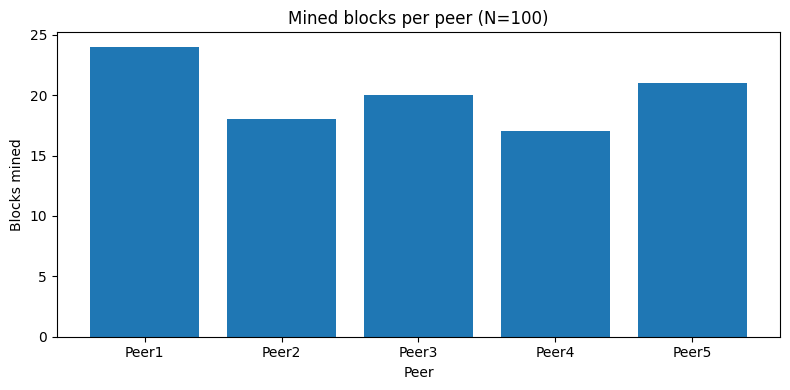

In [5]:
from blockchain.peer import BlockchainPeer
from blockchain.transaction import Transaction
import random
from collections import Counter
import matplotlib.pyplot as plt

N = 100
PEERS = 5
MAX_TX_PER_BLOCK = 5

peers = [BlockchainPeer(f'Peer{i}') for i in range(1, PEERS+1)]

for _ in range(N):
    miner = random.choice(peers)
    tx_count = random.randint(1, MAX_TX_PER_BLOCK)
    for j in range(tx_count):
        sender = f'Alice{random.randint(1,10)}'
        recipient = f'Bob{random.randint(1,10)}'
        miner.add_new_transaction(Transaction(sender, recipient, random.randint(1,100), 'data'))
    miner.mine()

counts = {peer.peer_name: len(peer.chain)-1 for peer in peers}
print(counts)


names = list(counts.keys())
values = [counts[n] for n in names]
plt.figure(figsize=(8,4))
plt.bar(names, values)
plt.title('Mined blocks per peer (N=100)')
plt.xlabel('Peer')
plt.ylabel('Blocks mined')
plt.tight_layout()
plt.savefig('hw2_task4.png')
print('Saved plot to hw2_task4.png')

For N >> 100 in an asynchronous distributed setup, the peer with slightly better luck or lower latency tends to mine more — but statistically, with equal mining power, counts will converge to roughly equal shares (binomial/Poisson fluctuations)

### Task5. Suppose all blocks have the same timestamp as the genesis block. Mine 5 blocks with transactions from task1 - use the peer name 'Satoshi'. Use the template below to override the updated mine() function with fixed timestamp.

### Find the hash of the block after the block from the task2.

#### Solution

In [ ]:
from blockchain import BlockchainPeer, BlockchainMainnet
import logging

class FixedTimeBlockchainPeer(BlockchainPeer):

    def mine(self):
        """
        Mine a block but force the timestamp to the genesis timestamp (0).
        This keeps all blocks with the same timestamp as genesis.
        """
        logging.info(f"{self.peer_name} | Start mining (fixed time)")

        if not self.unconfirmed_transactions:
            logging.info(f"{self.peer_name} | No transactions to mine")
            return

        last_block = self.last_block

        fixed_timestamp = 0
        new_block = Block(
            index=last_block.index + 1,
            transactions=self.unconfirmed_transactions,
            author=self.peer_name,
            timestamp=fixed_timestamp,
            previous_hash=last_block.hash,
            nonce=0,
        )
        proof = self.proof_of_work(new_block)
        logging.info(f"{self.peer_name} | Found proof {proof} (fixed time)")
        self._add_block(new_block, proof)
        self.unconfirmed_transactions = []
        self._announce()

In [10]:
from blockchain.transaction import Transaction
from blockchain.block import Block
import logging

from blockchain.peer import BlockchainPeer
BlockchainPeer.difficulty = 3

peer = FixedTimeBlockchainPeer('Satoshi')
txs = [
    Transaction('Alice', 'Bob', 10, 'Hello Bob!'),
    Transaction('Bob', 'Alice', 5, 'Hello Alice!')
]

for i in range(5):
    for tx in txs:
        peer.add_new_transaction(tx)
    peer.mine()
    print(f'Mined block index: {peer.last_block.index}, hash: {peer.last_block.hash}')

target_index = 5

b = peer.chain[target_index]
print('Block at index 5 hash:', b.hash)


Mined block index: 1, hash: 0001388e4938037f9c8ef8742d8debbc4200fd9309dbae57e3b081966cbeff65
Mined block index: 2, hash: 000743756a51234bf1898b90f79f8aa3e9151c1bf7d4b17414af8bccc5283d4e
Mined block index: 3, hash: 0009e52e043a9f83524d01485dda65fe16b6d0dd4239c1c938834be249a432e3
Mined block index: 4, hash: 0002e55332ede6e065fdc770f1ba8c026dbfa86b076a4369cf3aa49913629e21
Mined block index: 5, hash: 0000b74269d01b5160e499123ffa0e78e0d24ab0b9145cb06fcb4188cc43bdd9
Block at index 5 hash: 0000b74269d01b5160e499123ffa0e78e0d24ab0b9145cb06fcb4188cc43bdd9
